# **Fraud & Risk Detection in Financial Transactions**

In the rapidly evolving landscape of digital commerce, fraud detection remains a critical challenge.

With the support of IEEE-CIS, this project utilizes real-world transaction data from Vesta Corporation,  world’s leading payment service company, to develop predictive models that assess the likelihood of fraudulent transactions. The objective is to predict the probability of fraud by analyzing transaction and identity data to uncover patterns that differentiate legitimate from fraudulent activities.

## **Dataset Overview**

The dataset consists of two primary files (identity and transaction) which are linked by TransactionID; however, not all transactions have corresponding identity information. The data includes a variety of structured features, such as:

Transaction Features:
* **TransactionDT:** Timedelta from a reference point
* **TransactionAMT:** Transaction amount in USD
* **ProductCD:** Product category of the transaction

Card & Address Information:
* **card1 - card6:** Various card details, including type, category, issuing bank, and country
* **addr, dist:** Address and distance-based attributes

Email & Behavioral Features:
* **P_emaildomain, R_emaildomain:** Purchaser and recipient email domains
* **C1 - C14:** Count-based features related to addresses, payment cards, etc.
* **D1 - D15:** Timedelta features capturing time intervals between transactions

Identity & Risk Indicators:
* **M1 - M9:** Matching features (e.g., name on card vs. billing address)
* **Vxxx:** Engineered features created by Vesta, incorporating ranking, counting, and entity relations



Dataset from Kaggle: https://www.kaggle.com/c/ieee-fraud-detection/data

In [1]:
# Install libraries and packages to be used

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score, classification_report

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Load Training Data
train_transaction = pd.read_csv("/train_transaction.csv")
train_identity = pd.read_csv("/train_identity.csv")

In [3]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


## Exploratory Data Analysis on Transactions dataset

- Discover has a higher fraud rate potentially due to fewer transaction monitoring systems compared to Visa/Mastercard.

- Credit cards offer chargeback protection which may delay fraud detection and makes them a target for fraudsters; wheras, debit card fraud directly impacts a bank account which makes users more cautious. There is a need to implement secondary verification for credit transactions above a certain threshold.

- Most fraudulent transaction amounts are small with 50% ranging between 35 and 161 dollars as fraudsters use these for "card testing." Once verified, fraudsters make large unauthorized purchases ranging from 300 to 5000 dollars, as seen in the outliers.

- Majority of fraud transactions involve purchasing Product C possibly due to high demand.

In [5]:
# Check for missing values
train_transaction.isnull().sum().sort_values(ascending=False).head()

,0
dist2,552913
D7,551623
D13,528588
D14,528353
D12,525823


In [6]:
train_transaction['isFraud'].value_counts()

,count
isFraud,
0,569877
1,20663


In [7]:
train_transaction['isFraud'].value_counts(normalize=True)

,proportion
isFraud,
0,0.96501
1,0.03499


### Transactions dataset visualization

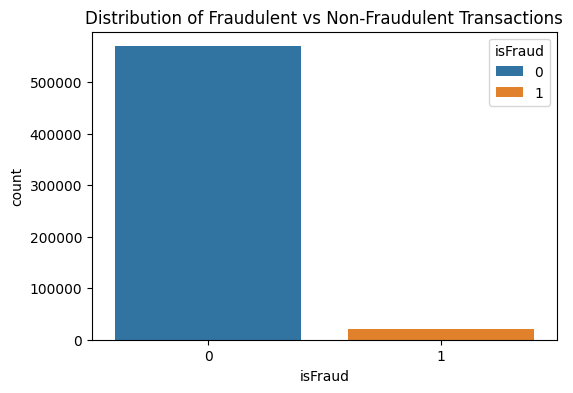

In [8]:
# Fraud Distribution

plt.figure(figsize=(6, 4))
sns.countplot(x='isFraud', data=train_transaction, palette="tab10", hue='isFraud')
plt.title('Distribution of Fraudulent vs Non-Fraudulent Transactions')
plt.show()

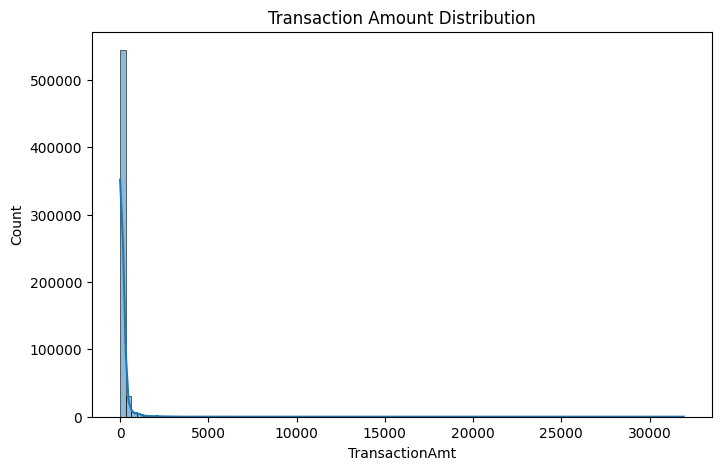

,TransactionAmt
count,590540.000000
mean,135.027176
std,239.162522
min,0.251000
25%,43.321000
50%,68.769000
75%,125.000000
max,31937.391000


In [9]:
# Transaction Amount Distribution

plt.figure(figsize=(8,5))
sns.histplot(train_transaction['TransactionAmt'], bins=100, kde=True, color=sns.color_palette("tab10")[0])
plt.title('Transaction Amount Distribution')
plt.show()

train_transaction['TransactionAmt'].describe()

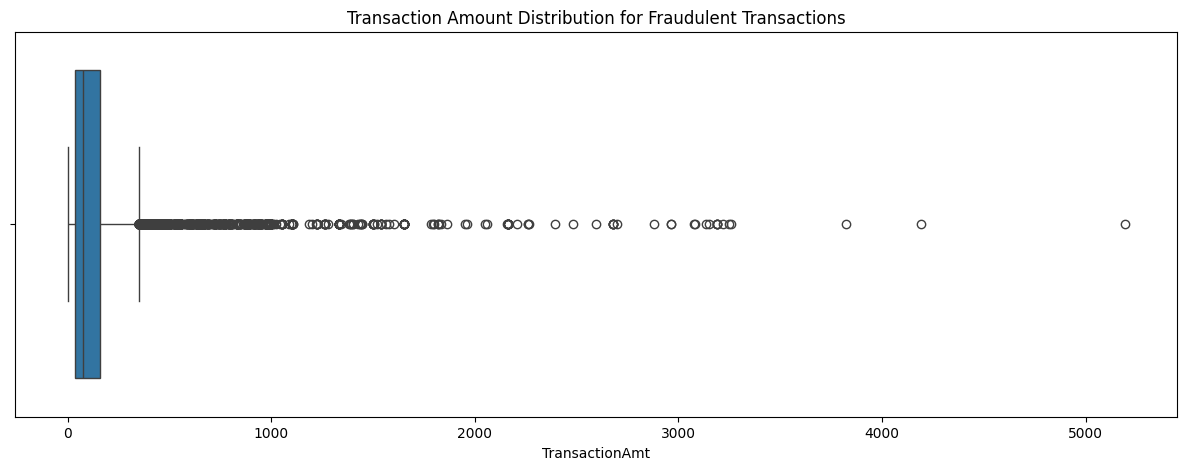

count    20663.000000
mean       149.244779
std        232.212163
min          0.292000
25%         35.044000
50%         75.000000
75%        161.000000
max       5191.000000
Name: TransactionAmt, dtype: float64


In [10]:
# Amounts Distribution for Fraudulent Transactions

plt.figure(figsize=(15,5))
sns.boxplot(x=train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt'], color=sns.color_palette("tab10")[0])
plt.title('Transaction Amount Distribution for Fraudulent Transactions')
plt.show()

print(train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt'].describe())

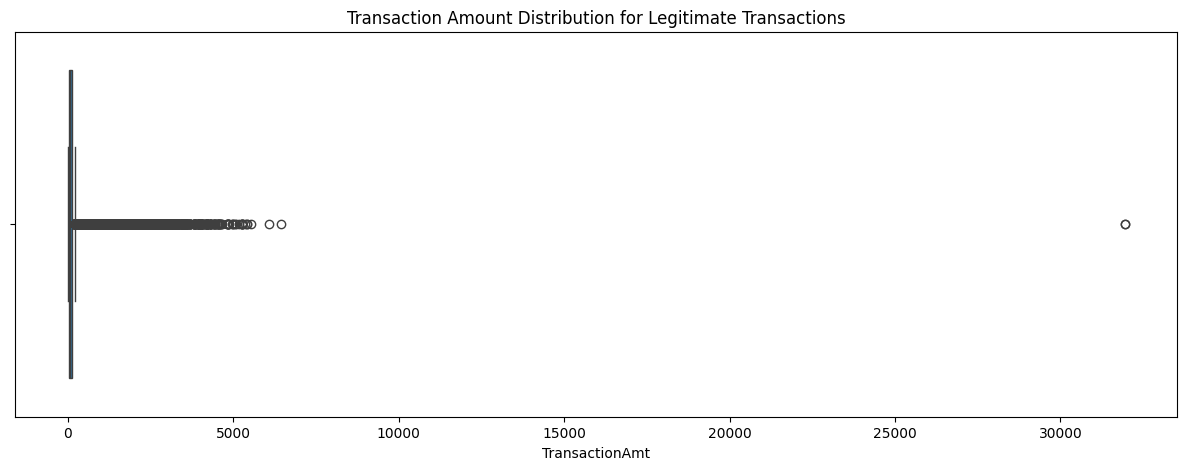

count    569877.000000
mean        134.511665
std         239.395078
min           0.251000
25%          43.970000
50%          68.500000
75%         120.000000
max       31937.391000
Name: TransactionAmt, dtype: float64


In [11]:
# Amounts Distribution for Legitimate Transactions

plt.figure(figsize=(15,5))
sns.boxplot(x=train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt'], color=sns.color_palette("tab10")[0])
plt.title('Transaction Amount Distribution for Legitimate Transactions')
plt.show();

print(train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt'].describe())

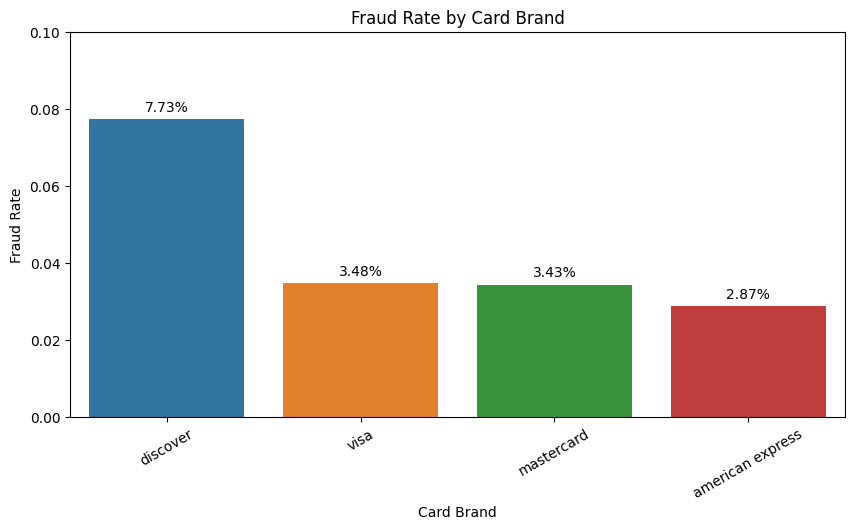

In [12]:
# Fraud rate by card brand

fraud_rate = train_transaction.groupby("card4")["isFraud"].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
ax = sns.barplot(x=fraud_rate.index, y=fraud_rate.values, hue=fraud_rate.index, palette="tab10", legend=False)
plt.ylim(0, 0.10)
for i, val in enumerate(fraud_rate):
    plt.text(i, val + 0.002, f"{val:.2%}", ha='center', fontsize=10)

plt.title("Fraud Rate by Card Brand")
plt.xlabel("Card Brand")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=30)

plt.show();

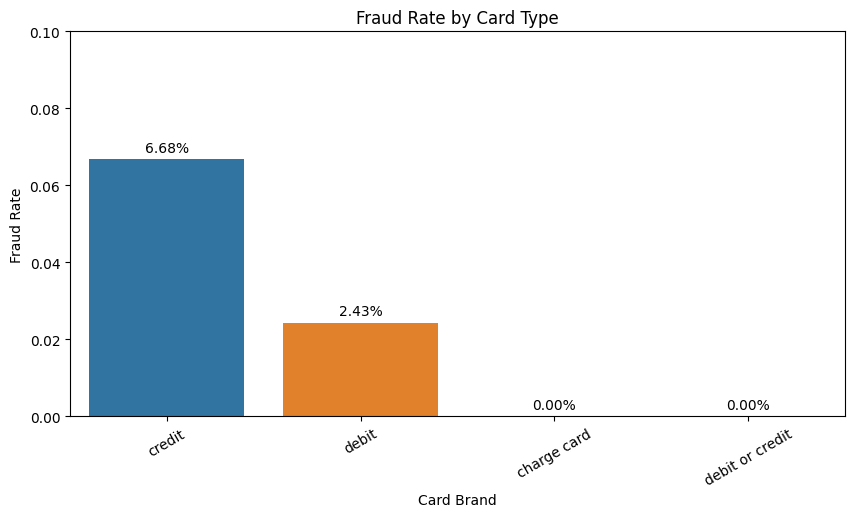

In [13]:
# Fraud Rate by Card Type

fraud_by_card_type = train_transaction.groupby("card6")["isFraud"].mean().sort_values(ascending=False)

plt.figure(figsize=(10,5))
ax = sns.barplot(x=fraud_by_card_type.index, y=fraud_by_card_type.values, hue=fraud_by_card_type.index, palette="tab10", legend=False)
plt.ylim(0, 0.10)

for i, val in enumerate(fraud_by_card_type):
    plt.text(i, val + 0.002, f"{val:.2%}", ha='center', fontsize=10)

plt.title("Fraud Rate by Card Type")
plt.xlabel("Card Brand")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=30)

plt.show();

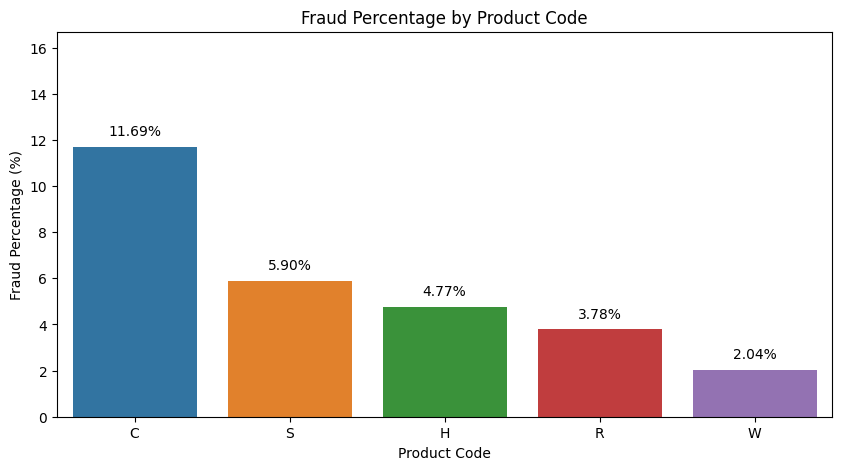

In [14]:
# Fraud Percentage by Product Code

product_fraud_percentage = (train_transaction.groupby('ProductCD')['isFraud'].mean()*100).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=product_fraud_percentage.index, y=product_fraud_percentage.values, palette="tab10", hue=product_fraud_percentage.index)
plt.title("Fraud Percentage by Product Code")
plt.xlabel("Product Code")
plt.ylabel("Fraud Percentage (%)")
plt.ylim(0, product_fraud_percentage.max() + 5)

for i, val in enumerate(product_fraud_percentage):
    plt.text(i, val + 0.5, f"{val:.2f}%", ha='center', fontsize=10)

plt.show();

## Exploratory Data Analysis on Identity dataset

- Use of mobile and desktop for fraud transactions is immaterial as both are almost within the same range.
- Majority of fraudulent transactions are made using Windows devices then followed by iOS devices.



In [15]:
train_identity.isnull().sum().sort_values(ascending=False).head()

,0
id_24,139486
id_25,139101
id_07,139078
id_08,139078
id_21,139074


In [16]:
train_identity['TransactionID'].nunique()

144233

In [17]:
# Merge transaction and identity datasets for match Fraud behavior
train_data = train_transaction.merge(train_identity, on="TransactionID", how="left")

### Identity dataset visualization

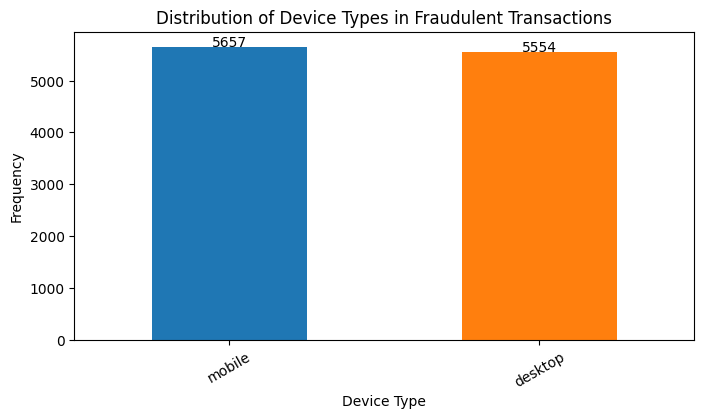

In [18]:
# DeviceType distribution for fraudulent transactions

fraud_transactions = train_data[train_data['isFraud'] == 1]
device_type_counts = fraud_transactions['DeviceType'].value_counts()

plt.figure(figsize=(8, 4))
device_type_counts.plot(kind='bar', color=sns.color_palette("tab10"))
plt.title('Distribution of Device Types in Fraudulent Transactions')
plt.xlabel('Device Type')
plt.ylabel('Frequency')
plt.xticks(rotation=30)

for i, val in enumerate(device_type_counts):
    plt.text(i, val + 0.5, f"{val}", ha='center', fontsize=10)

plt.show();


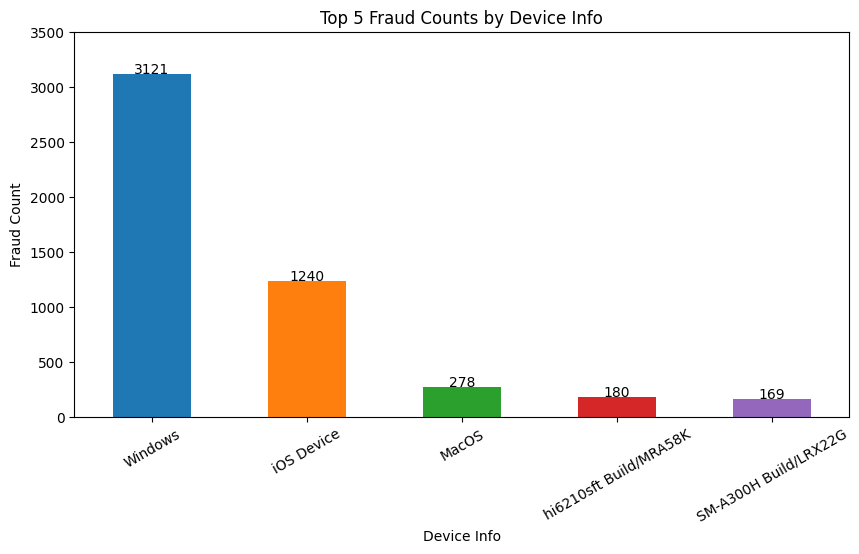

In [19]:
# Top Device Info for Fraudulent Transactions

device_info_fraud_counts = train_data.groupby('DeviceInfo')['isFraud'].sum().sort_values(ascending=False)

top_5_device_info_counts = device_info_fraud_counts.head(5)

plt.figure(figsize=(10, 5))
top_5_device_info_counts.plot(kind='bar', color=sns.color_palette("tab10"))
plt.title('Top 5 Fraud Counts by Device Info')
plt.xlabel('Device Info')
plt.ylabel('Fraud Count')
plt.ylim(0, 3500)
plt.xticks(rotation=30)

for i, val in enumerate(top_5_device_info_counts):
    plt.text(i, val + 0.5, f"{val}", ha='center', fontsize=10)

plt.show();

## Data Preprocessing

Missing values were imputed using median values for numerical fields and mode values for categorical fields.

Only selected numerical features were included such transaction details, card information, address data, and distance metrics which are used to assess the likelihood of a transaction being fraudulent. These are to be used as training dataset together with the target outcome (Fraud or Not Fraud).

The dataset was normalized so that all features have a similar scale which helps the model learn more effectively. It was then split into a training set and a testing set.

In [20]:
# Replace numerical missing values with median
for col in train_data.select_dtypes(include=['number']).columns:
    train_data[col] = train_data[col].fillna(train_data[col].median())

# Replace non-numeric missing values with mode
for col in train_data.select_dtypes(exclude=['number']).columns:
    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])

In [21]:
# Select Features and Target
features = ['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2']
X, y = train_data[features], train_data['isFraud']

In [22]:
# Standardize Features
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(scaler.fit_transform(X), y, test_size=0.3, random_state=42)

## Model Building

The Random Forest Classifier was used because it effectively analyzes different patterns in data making it ideal for detecting fraud in transactions. Using 100 decision trees makes the model more reliable in predicting risks while balancing performance and efficiency.

In [23]:
# Train Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

## Model Evaluation

The model shows a solid 97% accuracy but the large imbalance between non-fraudulent and fraudulent transactions (170,821 versus 6,341) makes it harder for the model to effectively detect fraud.

While it does a great job identifying non-fraudulent transactions, the model struggles with fraudulent ones which results in lower recall and precision. This leads to 3,779 fraudulent transactions being missed (false negatives) and 1,274 non-fraudulent ones incorrectly flagged as fraudulent (false positives).

In [24]:
# Classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    170821
           1       0.67      0.40      0.50      6341

    accuracy                           0.97    177162
   macro avg       0.82      0.70      0.74    177162
weighted avg       0.97      0.97      0.97    177162



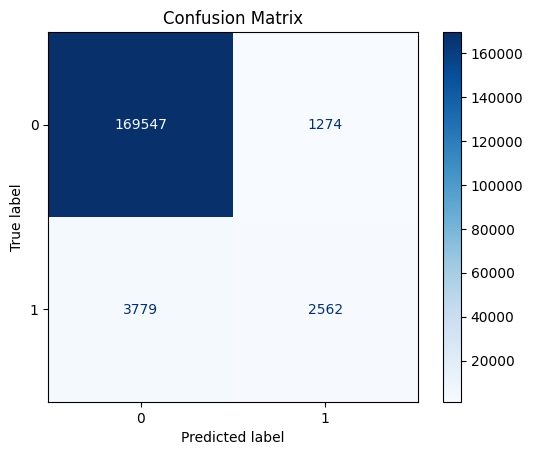

In [25]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

The ROC curve shows the trade-off between the True Positive Rate (TPR) and the False Positive Rate (FPR) at different thresholds. The AUC of 0.87 indicates the model can effectively distinguish between fraudulent and non-fraudulent transactions.

The ROC curve helps identify the best threshold to improve fraud detection while managing FPR. Improving TPR reduces false negatives, which is critical for detecting fraud, and controlling FPR prevents non-fraudulent transactions from being incorrectly flagged.

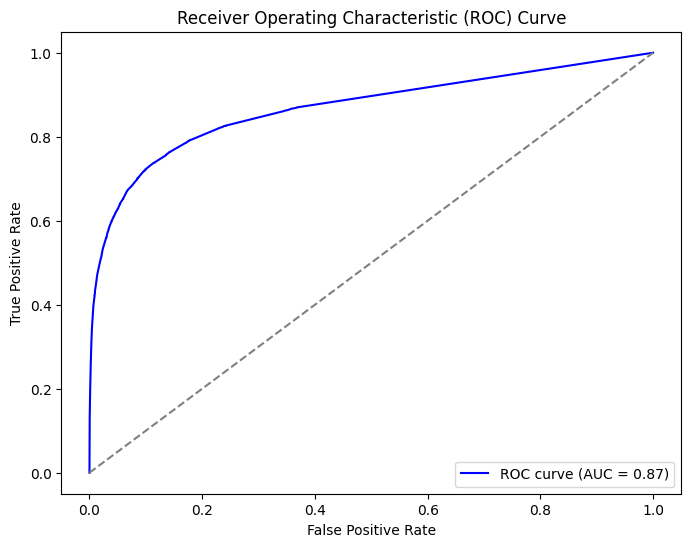

In [26]:
# ROC Curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

Precision-Recall curve, trade-off between precision and recall, is helpful when assessing the performance of a model with imbalanced data. With an AP score of 0.50, this shows moderate performance but needs improvement.

In fraud detection, high precision reduces false positives; however, a score of 0.50 means half of the predicted frauds may not be real fraud. Recall is also important to ensure most frauds are caught and the model needs better balance between the two.

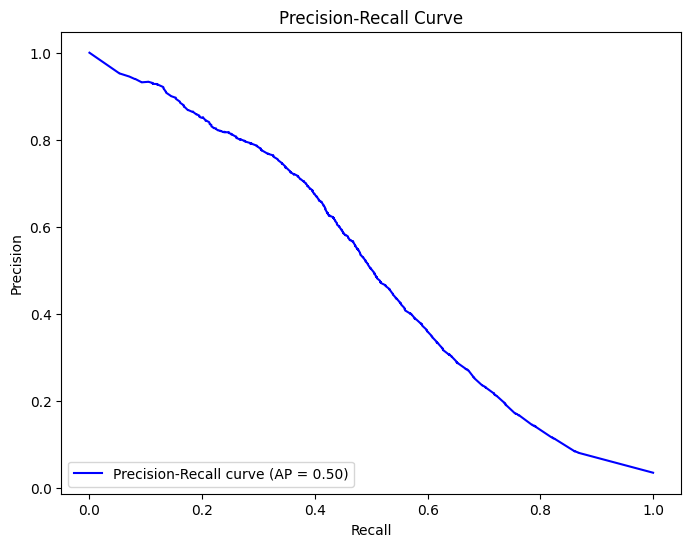

In [27]:
# Precision-Recall Curve

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

The transaction amount is the most important factor in predicting fraud, as large transactions are often linked to fraud. Monitoring high-value transactions can help detect fraud early.

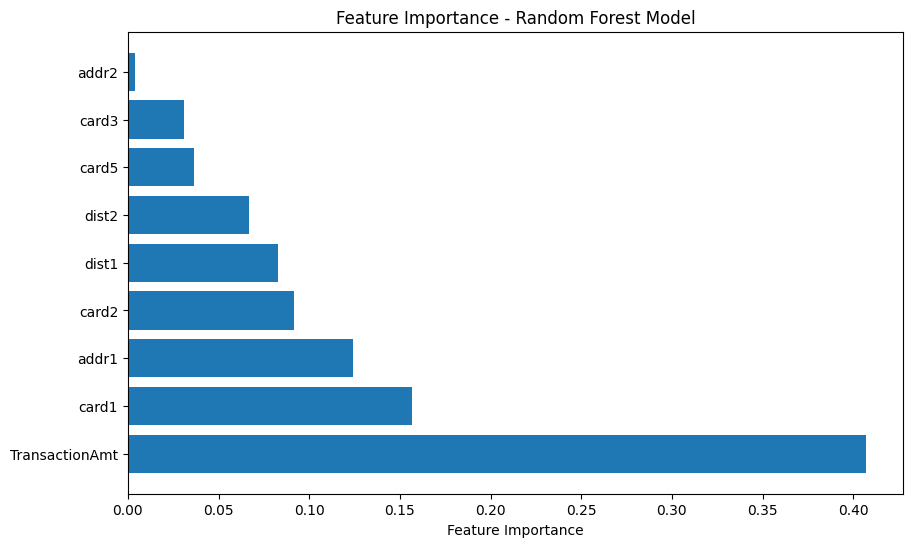

In [28]:
# Plot Feature Importance

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance - Random Forest Model')
plt.show()

## Recommendations

- Improve recall for fraudulent transactions detection and address class imbalance using techniques like oversampling or SMOTE.

- Focus monitoring on high-value transactions which are often linked to fraud.

- Improve verification processes for card transactions by using multi-factor authentications to reduce fraud risks.

- Monitor transactions that occur far from the cardholder’s location to detect suspicious behavior.